# Auditory category analysis

### Introduction:
Here I will analyze the category data for different stimuli. In this analysis, each cell will represent a dimension in a high dimensional "neural space." We are using the mean df/f response to being with. We will then see how different types of stimulus morphing is represented in the space.

### Programming:
We are using Python 2.7 as the programming language with pandas dataframes and numpy. Numpy is Python's linear algebra library of choice. Pandas is a dataframe library that allows efficient storage and analysis with arbitrarily large datasets. 

In [161]:
# import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

In [21]:
# Load data in a Pandas dataframe
fn = "fixed_data.csv"
df = pd.read_csv(fn, header=0)
header = df.columns.values

In [93]:
# Filter out all cells that have empty entries. Only want the good stuff!
N = len(df)
bad_idx = []
for h in header:
    A = np.where(np.isnan(df[h]))
    for a in A[0]:
        if a in bad_idx:
            continue
        else:
            bad_idx.append(a)

good_idx = []
for i in range(N):
    if i in bad_idx:
        continue
    else:
        good_idx.append(i)

In [106]:
# Organize data
dff_data = df[header[1:10]].T.values[:,good_idx]
fast_data = df[header[11:14]].T.values[:,good_idx]
slow_data = df[header[15:17]].T.values[:,good_idx]
pitch_m10_data = df[header[np.array([18, 21])]].T.values[:,good_idx]
pitch_m20_data = df[header[np.array([19,22])]].T.values[:,good_idx]
pitch_p5_data = df[header[np.array([20, 23])]].T.values[:,good_idx]

data = [dff_data, fast_data, slow_data, pitch_m10_data, pitch_m20_data, pitch_p5_data]
categories = ["dff", "fast", "slow", "pitch -10", "pitch -20", "pitch +5"]

N = len(good_idx)

### MultiDim Class:
This is a Python class that will allow us to work with multidimensional spaces. This will grow over time.

In [116]:
class MultiDim:

    def Mean(self, data):
        """
        multidimensional arithmetic mean. 
        
        data: mxn matrix, where n is dimensionality of space and m is 
              number of samples
        """
        return np.nanmean(data, 0)
        

    def Var(self, data):
        return np.nanvar(data, 0)
    
    
    def Distance(self, a, b, distance='euclidean'):
        """
        Get distance between two points in n dimesnional space
        
        a: n dim vector
        b: n dim vector
        distance: [euclidean], distance metric to use. only euclidean 
                  distance supported for now.
        """
        return np.linalg.norm( a - b )
    
    
    def Radius(self, data, distance='euclidean'):
        """
        Get radius of ball, defined by distance of furthest point from mean
        
        data: mxn matrix, where n is dimensionality of space and m is 
              number of samples
              
        distance: [euclidean], is distance metric to use. Only euclidean 
                  distance supported for now.
        """
        mean = self.Mean(data)
        m = np.shape(data)[0]
        radius = 0
        for i in range(m):
            tmp = self.Distance( mean, data[i,:], distance=distance )
            if tmp > radius:
                radius = tmp
        return radius
    
    
    def ConstructDistanceMatrix( self, points, distance='euclidean' ):
        """
        Construct a distance matrix between given points
        
        points: mxn matrix, where n is dimensionality of space and m is
                number of points
        
        distance: [euclidean], is distance metric to use. Only euclidean
                  distance supported for now
                  
        A: mxm symmetric matrix where element [i,j] is distance between 
           points i and j. 
        """
        m = np.shape(points)[0]
        A = np.zeros( (m,m) )
        for i in range(m):
            for j in range(i, m):
                A[i,j] = self.Distance( points[i,:], points[j,:], distance=distance )
                A[j,i] = A[i,j]
        return A
    
    def MDS(self, A ):
        """
        Classical MDS
        
        A: nxn matrix. Should be symmetric. Represents distances
        
        Y: (n, p) configuration matrix where each column is a dimension.
           only returns up to p dimensions (positive eigenvalues)
        
        eval: eigenvalues
        """
        n = len(A)
        H = np.eye(n) - np.ones((n,n))/n
        B = -H.dot(np.square(A)).dot(H)/2

        evals, evecs = np.linalg.eigh(B)

        idx = np.argsort(evals)[::-1]
        evals = evals[idx]
        evecs = evecs[:,idx]

        w, = np.where(evals > 0)
        L = np.diag(np.sqrt(evals[w]))
        V = evecs[:,w]
        Y = V.dot(L)

        return Y, evals

### Transforming the space:

Here we will assume that each of the conditions represent a different cateogry. We assume euclidean distance everywhere (no reason to believe this, implies linearity and therefore simplest assumption). 

We will find a lower dimensional subspace that maximizes the pairwise distance between the different categories. Everything is linear, so classical MDS will be used.

In [178]:
MD = MultiDim()

means = []
radii = []
for d in data:
    means.append(MD.Mean(d))
    radii.append(MD.Radius(d))

means = np.array(means)
radii = np.array(radii)
distance_matrix = MD.ConstructDistanceMatrix( means )

mds_Y, mds_evals = MD.MDS( distance_matrix )

In [179]:
Y = np.dot(mds_Y.T[:2,:], distance_matrix)

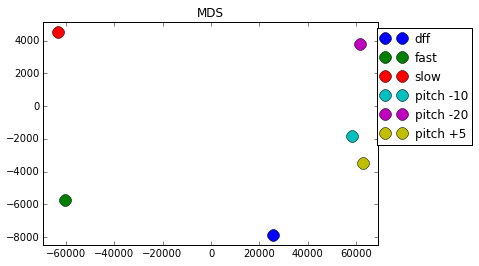

In [180]:
fig, ax = plt.subplots()
ax.margins(0.05)
for i in range(np.shape(Y)[1]):
    ax.plot(Y[0,i], Y[1,i], marker='o', linestyle='', ms=12, label=categories[i])
    #ax.add_patch(patches.Circle((Y[0,i], Y[1,i]), radii[i]))
ax.legend(bbox_to_anchor=(1.3, 1))
plt.title("MDS")

### TODO:

* Find scaling factor to plot radii in MDS space.